In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')
import kagglehub

<img src="https://miro.medium.com/max/1400/1*6BFOIdSHlk24Z3DFEakvnQ.png">

In [2]:
!pip install --upgrade kagglehub

path = kagglehub.dataset_download("adityajn105/flickr8k")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 1.9 MB/s eta 0:00:00
  Attempting uninstall: kagglehub
    Found existing installation: kagglehub 0.3.5
    Uninstalling kagglehub-0.3.5:
      Successfully uninstalled kagglehub-0.3.5


100%|██████████| 1.04G/1.04G [00:05<00:00, 193MB/s]

Extracting files...


In [3]:
data = pd.read_csv("captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


Skipping malformed line: 1012212859_01547e3f17.jpg,"A dog shakes its head near the shore , a red ball next to it ."

Skipping malformed line: 1012212859_01547e3f17.jpg,"Dog with orange ball at feet , stands on shore shaking off water"

Skipping malformed line: 1022454332_6af2c1449a.jpg,"Two people are at the edge of a lake , facing the water and the city skyline ."

Skipping malformed line: 1022454428_b6b660a67b.jpg,"A couple and an infant , being held by the male , sitting next to a pond with a near by stroller ."

Skipping malformed line: 103106960_e8a41d64f8.jpg,"Hockey goalie boy in red jacket crouches by goal , with stick ."

Skipping malformed line: 103205630_682ca7285b.jpg,"Two men , standing on an ice , looking into something covered with a blue tarp ."

Skipping malformed line: 1042590306_95dea0916c.jpg,"Asian man and blond woman holding hands outdoors , man in background watches ."

Skipping malformed line: 105342180_4d4a40b47f.jpg,"A girl paddling down a large river , as see

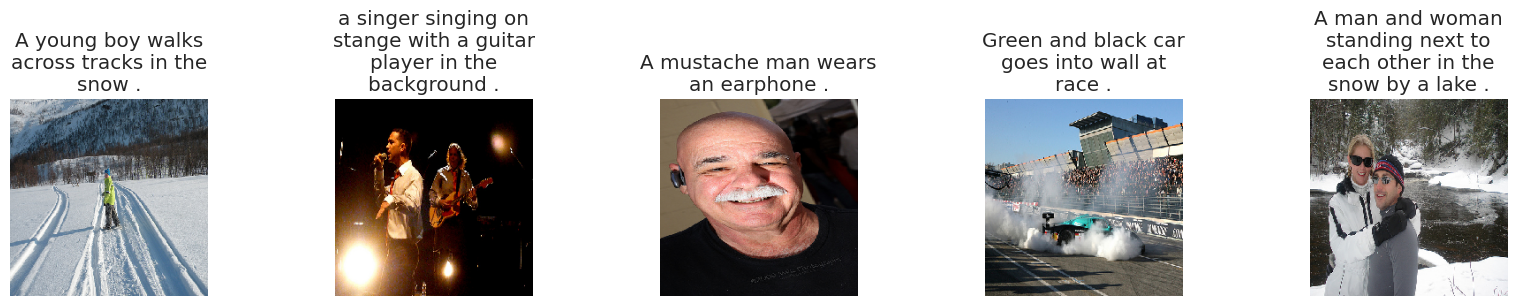

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from textwrap import wrap

def readImage(img_path, img_size=224):
    """
    Read and preprocess a single image.
    """
    if os.path.exists(img_path):
        img = load_img(img_path, color_mode='rgb', target_size=(img_size, img_size))
        img = img_to_array(img)
        img = img / 255.0  # Normalize the image
        return img
    else:
        raise FileNotFoundError(f"Image not found at path: {img_path}")

def display_images(temp_df, image_dir, img_size=224):
    """
    Display images with their corresponding captions.
    """
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(len(temp_df)):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)

        # Read the corresponding image
        img_path = os.path.join(image_dir, temp_df.loc[i, "image"])  # Ensure column matches DataFrame structure
        try:
            image = readImage(img_path, img_size=img_size)
            plt.imshow(image)
        except FileNotFoundError as e:
            print(e)
            continue

        # Display caption
        plt.title("\n".join(wrap(temp_df.loc[i, "caption"], 20)))
        plt.axis("off")

# Adjust the paths to the downloaded dataset
path = "/root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1"
captions_file = os.path.join(path, "captions.txt")  # Verify the exact location of captions.txt

# Read the captions dataset
with open(captions_file, "r") as file:
    lines = file.readlines()

# Read and parse captions.txt
captions_data = []
for line in lines[1:]:  # Skip the first line (header)
    # Skip empty lines
    if line.strip() == "":
        continue

    parts = line.split(",")  # Assuming comma-separated format
    if len(parts) == 2:  # Ensure the line contains both image_name and caption
        image_name = parts[0].strip()  # Strip extra spaces
        caption = parts[1].strip()  # Strip extra spaces
        captions_data.append([image_name, caption])
    else:
        print(f"Skipping malformed line: {line}")

# Convert to DataFrame
data = pd.DataFrame(captions_data, columns=["image", "caption"])

# Debugging step: Print the first few rows of the DataFrame to verify
print(f"DataFrame shape: {data.shape}")
print("First 5 rows of the DataFrame:")
print(data.head())

# If the DataFrame has fewer than 30 rows, sample the available ones
sample_size = min(5, len(data))
print(f"Sampling {sample_size} entries from {len(data)} available rows.")

# Sample the entries and display their images and captions
image_dir = os.path.join(path, "Images")  # Correct the 'Images' folder path (case-sensitive)
display_images(data.sample(sample_size), image_dir)


# **Visualization**
- Images and their corresponding captions

In [12]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

## __Preprocessed Text__

In [13]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 17, 305, 61, 190, 115, 2]

In [17]:
# Define the image directory path
image_path = "/root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/Images"  # Adjust if necessary

# Initialize model
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

# Image size
img_size = 224
features = {}

# Process each image
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Extract features using the model
    feature = fe.predict(img, verbose=0)


    features[image] = feature


  1%|          | 69/8091 [00:28<55:43,  2.40it/s]


KeyboardInterrupt: 

In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [ ]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:
plot_model(caption_model)

In [ ]:
caption_model.summary()

In [ ]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
model_name = "model.keras"  # Change the file extension to .keras

checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=1,
                              restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)


## **Let's train the Model !**

<img src='https://miro.medium.com/max/1400/1*xIXqf46yYonSXkUOWcOCvg.gif'>

In [ ]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [ ]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [ ]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

In [ ]:
display_images(samples)